Notebook utilizzato per la selezione dei parametri da utilizzare nel bdt. Si utilizza una grid search seguita da cross validation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pickle

## Data preliminary

Setting weigths for background, plotting distributions and correlations of features

In [2]:
%run analysis_utils.py


In [3]:
df_PbPb_MC=pd.read_pickle('data_MC.pkl')

In [4]:
df_PbPb_MC['y']=(df_PbPb_MC['V0pt']>=0).astype(int)
bkg=df_PbPb_MC.query('y==0')
sig=df_PbPb_MC.query('y==1')

In [5]:
df_PbPb_MC.head()

,V0pt,V0eta,LeastNumberOfXedRows,DistOverP,InvMass,ArmenterosAlpha,V0CosPA,V0Chi2,NegProngPt,PosProngPt,ProngsDCA,PosProngPvDCA,NegProngPvDCA,V0radius,LeastXedRowsOverFindable,MaxChi2perCluster,BlastWaveNum,y
0,8.688943,-0.013313,153.0,0.796662,3.029475,0.82,0.999902,2.48,0.4,8.30,0.14,0.066,0.256,7.259266,1.0,1.65,0.000440,1
1,4.151622,-0.039293,131.0,4.243147,3.008546,0.85,0.999773,0.32,0.2,4.00,0.82,0.256,0.256,17.417938,1.0,1.95,0.073260,1
2,2.367249,-0.199687,153.0,4.027225,2.986696,0.71,0.999677,0.12,0.2,2.15,0.47,0.256,0.256,9.352267,1.0,1.80,0.252804,1
3,2.016504,-0.348386,130.0,21.513483,2.972697,0.64,0.999324,0.00,0.2,1.80,0.88,0.256,0.256,43.288944,1.0,1.20,0.298774,1
4,5.946270,0.145832,150.0,4.019067,2.996598,0.65,0.999867,0.00,0.6,5.35,0.08,0.071,0.256,24.168137,1.0,1.40,0.012367,1


In [6]:
l=sum(sig['BlastWaveNum'])
bkg['BlastWaveNum']=l/len(bkg)

In [6]:
data=pd.concat([bkg,sig],ignore_index=True)
data=data.sample(frac=1)

In [7]:
data.head()

,V0pt,V0eta,LeastNumberOfXedRows,DistOverP,InvMass,ArmenterosAlpha,V0CosPA,V0Chi2,NegProngPt,PosProngPt,ProngsDCA,PosProngPvDCA,NegProngPvDCA,V0radius,LeastXedRowsOverFindable,MaxChi2perCluster,BlastWaveNum,y
1752728,-7.873686,-0.429825,158.0,0.232110,2.999024,0.84,0.966833,1.96,0.35,7.55,0.25,0.256,0.064,2.063289,1.0,1.70,4.128098e-07,0
2448388,4.537557,-0.235714,135.0,1.316132,2.992647,-0.67,0.999969,0.80,4.10,0.45,0.94,0.256,0.099,6.282749,1.0,1.90,5.196600e-02,1
3937305,5.960238,-0.328393,155.0,0.468724,2.972380,0.80,0.976906,0.20,0.30,5.65,0.33,0.256,0.167,2.506482,1.0,1.65,1.217734e-02,1
3545076,3.129287,0.263165,141.0,0.598063,3.070746,0.49,0.997993,10.24,0.50,2.65,1.13,0.055,0.256,1.850042,1.0,1.90,1.602882e-01,1
504266,-2.367059,0.483328,117.0,1.213392,2.990143,-0.82,0.995403,0.00,2.25,0.15,0.91,0.256,0.051,3.139992,1.0,2.20,4.128098e-07,0


In [8]:
training_columns=['PosProngPvDCA', 'NegProngPvDCA', 'V0CosPA', 'ProngsDCA', 'DistOverP', 'ArmenterosAlpha', 'LeastNumberOfXedRows','MaxChi2perCluster','V0eta']

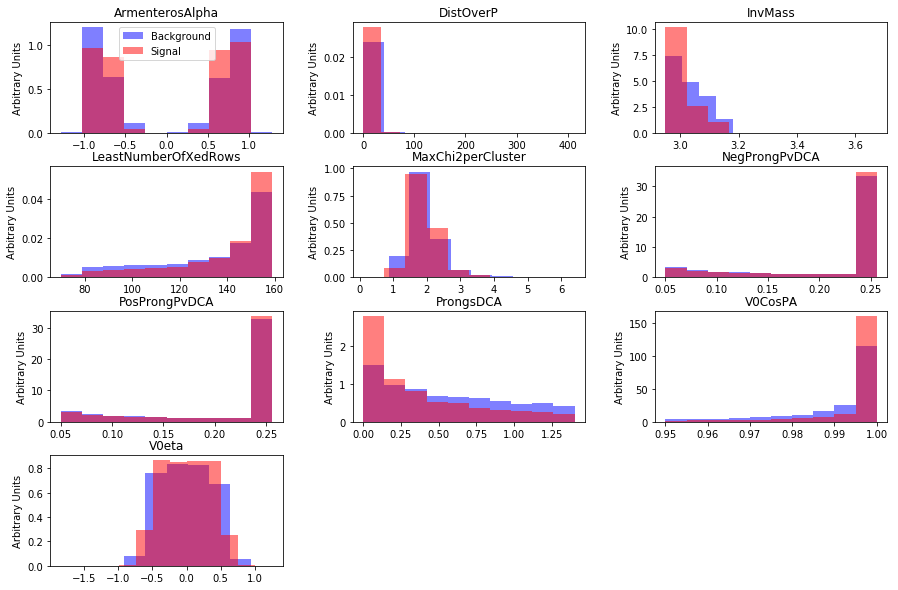

In [9]:
plot_distr(data,training_columns+['InvMass'])

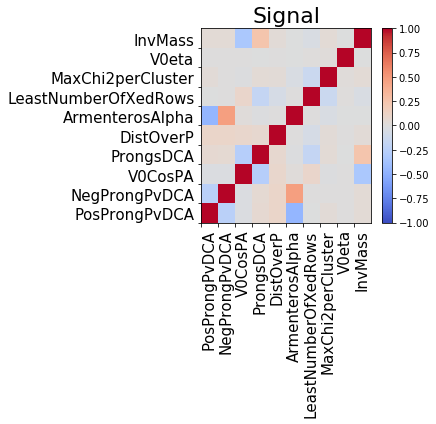

In [10]:
plot_corr(data,training_columns+['InvMass'],"Signal")

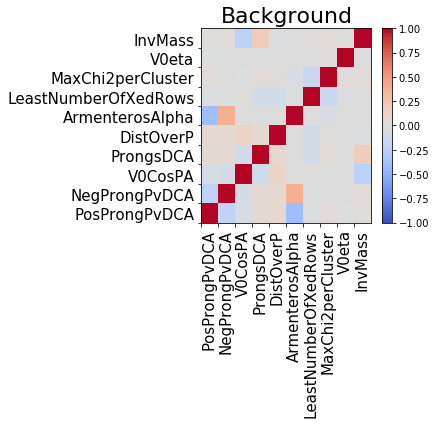

In [11]:
plot_corr(data,training_columns+['InvMass'],"Background")

In [12]:
y_target=data["y"]

In [13]:
data=data.drop(["y"],axis=1)

In [14]:
splitpoint=int(len(data)/2)


In [15]:
traindata=data[0:splitpoint]
ytrain=y_target[0:splitpoint]
testdata=data[splitpoint+1:]
ytest=y_target[splitpoint+1:]

## Parameters Optimization

Transforming in xgb Matrix. Optimization with cross validation,tuning of parameters, and final training

In [16]:
dtrain = xgb.DMatrix(data=traindata[training_columns], label=ytrain, feature_names=training_columns, silent=True)

/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/fmazzasc/.local/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [17]:
dtest = xgb.DMatrix(data=testdata[training_columns], label=ytest, feature_names=training_columns, silent=True)

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist'}

In [22]:
def optimize_params(dtrain,par):
    %run analysis_utils-Copy1.py
    gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(2, 10, 2)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(0, 12, 2)]},
          }
    par['max_depth'],par['min_child_weight'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    
    gs_dict = {'first_par': {'name': 'subsample', 'par_values': [i/10. for i in range(4, 10)]},
           'second_par': {'name': 'colsample_bytree', 'par_values': [i/10. for i in range(8, 10)]},
          }
    par['subsample'],par['colsample_bytree'],_ = gs_2par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'gamma', 'par_values': [i/10. for i in range(0, 11)]}} 
    par['gamma'],_ = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    gs_dict = {'first_par': {'name': 'eta', 'par_values': [0.1, 0.05, 0.01, 0.005, 0.001]}}
    par['eta'],n = gs_1par(gs_dict, par, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    return n

In [ ]:
%time
nround = optimize_params(dtrain,params)

CPU times: user 36 µs, sys: 0 ns, total: 36 µs
Wall time: 58.9 µs


In [ ]:
early_stopping_rounds

In [19]:
best_model = xgb.train(params, dtrain,num_boost_round=num_rounds)

In [53]:
gs_dict = {'first_par': {'name': 'max_depth', 'par_values': [i for i in range(7, 10, 1)]},
           'second_par': {'name': 'min_child_weight', 'par_values':[i for i in range(7, 10, 1)]},
          }
params['max_depth'],params['min_child_weight'],_ = gs_2par(gs_dict, params, dtrain, num_rounds, 42, cv, scoring, early_stopping_rounds)
    

In [31]:
best_model = xgb.train(params, dtrain,num_boost_round=num_rounds)

## Test

Roc curve, feature importance, output of the model and distributions of the features with different cuts on bdt score

ROC_AUC traininig set: 0.746724


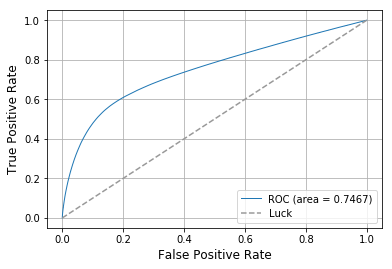

In [34]:
y_pred= best_model.predict(dtest,output_margin=True)
print(f"ROC_AUC traininig set: {roc_auc_score(ytest, y_pred):.6f}")
plot_roc(ytest, y_pred)

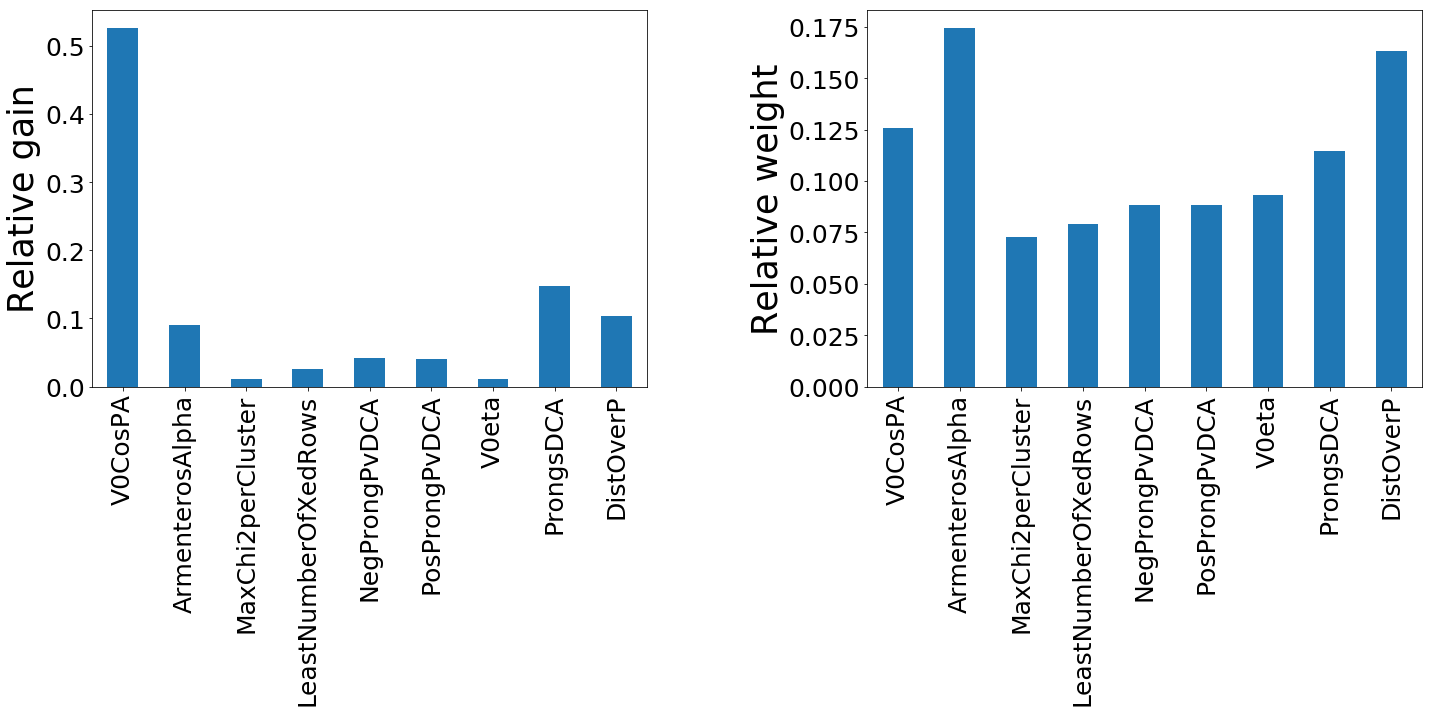

In [35]:
plot_feature_imp(best_model,['gain','weight'])

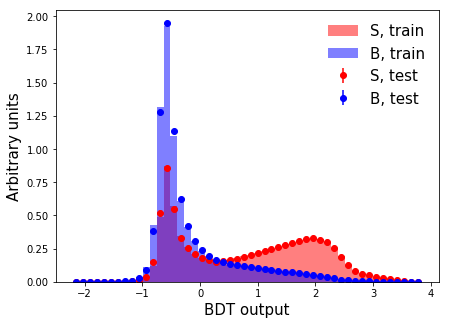

In [36]:
plot_output_train_test(best_model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

In [41]:
testdata['y']=ytest

/home/fmazzasc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


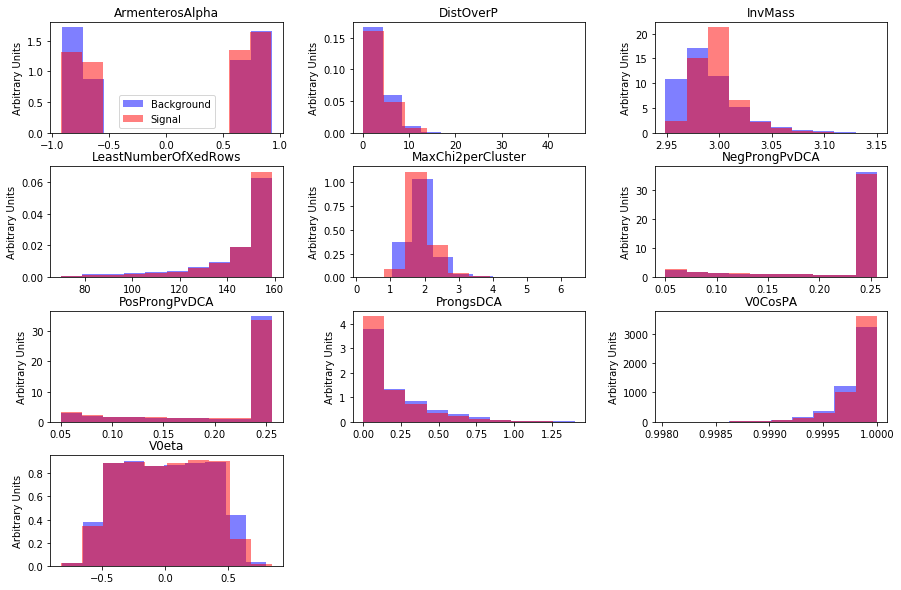

In [43]:
plot_distr(testdata[y_pred>1],training_columns+['InvMass'])